# Stromverbrauchsprognose unter Verwendung von Wetterdaten
In diesem Projekt soll anhand von bereitgestellten Wetter- und Energieverbrauchsinformationen eine Prognose für den Energieverbrauch 1h bzw. 24h nach vorne erstellt werden. Als Zeitraum werden hierfür die Monate Juni bis August 2011 untersucht.

## Setup
Test

In [69]:
#
import pandas as pd

#
import matplotlib.pyplot as plt
import seaborn as sns

#Show mulitple outputs within one kernel-----------------------
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
#pd.set_option('display.float_format', lambda x: '%.3f' % x) #diplay command only show the first 5 digits

# 1. Überblick und  Datenbereinigung 
Wir arbeiten hierfür mit zwei Datensätzen.
* 'SystemLevelSummer.csv' enthält Informationen zum Stromverbrauch. 
* 'weatherDFLocalSummer.csv' enthält Wetterinformationen, welche im Wesentlichen vorhergesagt werden sollen.

## 1.1 Laden der Datensätze

In [70]:
powerDF = pd.read_csv('./data/SystemLevelSummer.csv')
weatherDF = pd.read_csv('./data/WeatherLocalSummer.csv')

In [71]:
powerDF.columns
powerDF

Index(['#DATE', ' TOTAL_LOAD'], dtype='object')

,#DATE,TOTAL_LOAD
0,2011-06-01 00:15,639691.499583
1,2011-06-01 00:30,624777.006874
2,2011-06-01 00:45,610658.780201
3,2011-06-01 01:00,597351.542302
4,2011-06-01 01:15,583547.506936
...,...,...
8827,2011-08-31 23:00,847367.609038
8828,2011-08-31 23:15,822442.490218
8829,2011-08-31 23:30,802867.468608
8830,2011-08-31 23:45,784569.419215


In [72]:
powerDF.iloc[1]

#DATE          2011-06-01 00:30
 TOTAL_LOAD       624777.006874
Name: 1, dtype: object

In [73]:
weatherDF.columns
weatherDF.head()

Index(['# DATE', ' TEMPERATURE [F]', ' HUMIDITY [%]', ' PRESSURE [inHg]',
       ' WIND_SPEED [m/s]', ' RAINFALL [mm]'],
      dtype='object')

,# DATE,TEMPERATURE [F],HUMIDITY [%],PRESSURE [inHg],WIND_SPEED [m/s],RAINFALL [mm]
0,2011-05-30 17:00,86.635,51.563,29.941,7.523,0.0
1,2011-05-30 18:00,84.931,56.044,29.945,7.453,0.0
2,2011-05-30 19:00,83.100,61.551,29.952,6.930,0.0
3,2011-05-30 20:00,80.823,69.142,29.967,6.979,0.0
4,2011-05-30 21:00,79.305,75.395,29.983,6.677,0.0


## 1.2 Überarbeitung der Datenstruktur
Nachfolgend sollen die Datensätze so überarbeitet werden, damit diese im weiteren Verlauf sinnvoll untersucht werden können.  
<span style="color:red;">Was wird genau gemacht?</span>

In [74]:
def generalModification(df):
    #General Modifications---------------------
    df.columns = df.columns.str.replace(" ", "")

    #Date Modifications------------------------
    df['#DATE'] = pd.to_datetime(df['#DATE'])
    df = df.set_index('#DATE').sort_index()
    df.index = df.index.tz_localize('UTC') #ensure timezone-aware format for further modifications

    #Separate the datetime in separate columns
    df['MONTH'] = df.index.month
    df['DAY'] = df.index.day

    return df

In [75]:
powerDF = generalModification(powerDF)
weatherDF = generalModification(weatherDF)

Wir wollen NaN Werte in unserem Datensatz ausschließen, da diese das Arbeiten mit den Daten erschweren und beim Auftreten genauer betrachtet werden müssten. 
   
Zudem überprüfen wir gleich, ob wir Lücken innerhalb der Daten haben, also ob wir es mit einer kontinuierlichen Datenerfassung zu tun haben.  
Dazu betrachten wir jeweils die Differenz zweier aufeinanderfolgender Einträge und es soll bestimmt werden, ob diese von der zu Erwartetenden abweicht.


In [76]:
#detect NaN values in the two df
any(map(lambda df: df.isna().any().any(), [powerDF, weatherDF]))

False

In [77]:
#Ensure equal time periods between data
(powerDF.index.diff()[1:] == pd.Timedelta(minutes=15)).all()
(weatherDF.index.diff()[1:] == pd.Timedelta(minutes=60)).all()

True

True

Beides trifft in unserem Fall nicht zu und die DAten sind in den Punkten korrekt erfasst worden.

#### 1.2.1 Spezielle Überarbeitung powerDF
Zudem sind die Zeitabstände von powerDF ...., deswegen ... . 
Dazu rechnen wir die einzelnen Werte zusammen, da
(Möglich da keine Lücken)  
  
Dabei verwerfen wir den ersten und letzen Eintrag, da wir hierfür keine volle Stunde kriegen würden und somit die Puntke nicht mit dem Rest vergleichbar wären.

In [78]:
powerDF = powerDF.resample('h').sum()[1:-1]

Zudem ist die Größenordnung <span style="color:red;">...KW oder so, was du rausgefunden hast. eventuell noch genauer betonen wie viele Haushalte es sind, deutschlandweit o.ä....</span> und derart viele Nachkommastellen sind schlichtweg irrelevant und unmöglich so genau zu prognostizieren. Dementsprechend runden wir auf eine Nachkommastelle genau. Der Betrag der dabei im Worst-Case verloren geht ist äquivalent zu <span style="color:red;">Hier eine Recherche mit analogie wäre cool, so idk ein Kühlschrank</span>

In [79]:
powerDF['TOTAL_LOAD'] = powerDF['TOTAL_LOAD'].round(1)

#### 1.2.2 Spezielle Überarbeitung weatherDF
Fahrenheit zu Celcius

In [80]:
weatherDF['TEMPERATURE[F]'] = (weatherDF['TEMPERATURE[F]']-32)/1.8
weatherDF = weatherDF.rename(columns={'TEMPERATURE[F]': 'TEMPERATURE[C]'})

## 1.2 Überblick über die Daten 
Zunächst soll sich von den Datensätzen ein grober Überblick verschaffen werden, um sie gegebenenfalls sinnvoll zu bearbeiten bzw. aneinander anzupassen.
Aus dem Datensatz mit dem Stromverbrauch (Einheit kWh) ist bereits zu erkennen, dass die Messwerte im Zeitraum vom 01.06.2011 bis 01.09.2011 im 15-Minutentakt aufgenommen worden sind. Der Datensatz mit den Wetterdaten hingegen bezieht sich auf den Zeitraum 30.05.2011

In [81]:
powerDF.columns
powerDF

Index(['TOTAL_LOAD', 'MONTH', 'DAY'], dtype='object')

,TOTAL_LOAD,MONTH,DAY
#DATE,,,
2011-06-01 01:00:00+00:00,2312632.3,24,4
2011-06-01 02:00:00+00:00,2155474.9,24,4
2011-06-01 03:00:00+00:00,2067450.6,24,4
2011-06-01 04:00:00+00:00,2086290.8,24,4
2011-06-01 05:00:00+00:00,2221951.8,24,4
...,...,...,...
2011-08-31 19:00:00+00:00,4691375.7,32,124
2011-08-31 20:00:00+00:00,4468301.9,32,124
2011-08-31 21:00:00+00:00,4089121.2,32,124


In [82]:
weatherDF.columns
weatherDF

Index(['TEMPERATURE[C]', 'HUMIDITY[%]', 'PRESSURE[inHg]', 'WIND_SPEED[m/s]',
       'RAINFALL[mm]', 'MONTH', 'DAY'],
      dtype='object')

,TEMPERATURE[C],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-05-30 17:00:00+00:00,30.352778,51.563,29.941,7.523,0.0,5,30
2011-05-30 18:00:00+00:00,29.406111,56.044,29.945,7.453,0.0,5,30
2011-05-30 19:00:00+00:00,28.388889,61.551,29.952,6.930,0.0,5,30
2011-05-30 20:00:00+00:00,27.123889,69.142,29.967,6.979,0.0,5,30
2011-05-30 21:00:00+00:00,26.280556,75.395,29.983,6.677,0.0,5,30
...,...,...,...,...,...,...,...
2011-09-01 12:00:00+00:00,31.492222,55.515,29.945,5.650,0.0,9,1
2011-09-01 13:00:00+00:00,32.403889,49.891,29.923,5.407,0.0,9,1
2011-09-01 14:00:00+00:00,33.896667,41.848,29.895,5.461,0.0,9,1


In [83]:
powerDF.describe()
weatherDF.describe()

,TOTAL_LOAD,MONTH,DAY
count,2.207000e+03,2207.000000,2207.000000
mean,3.746181e+06,28.045310,63.374717
std,9.694753e+05,3.257147,35.410410
min,1.924936e+06,24.000000,4.000000
25%,2.855358e+06,24.000000,32.000000
50%,3.706778e+06,28.000000,64.000000
75%,4.583055e+06,32.000000,94.000000
max,5.719817e+06,32.000000,124.000000


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
mean,28.996319,64.212354,29.917043,3.917266,0.007017,6.998227,15.930408
std,3.580114,18.236110,0.075241,1.932054,0.059717,0.856951,9.026840
min,19.231667,21.227000,29.719000,0.000000,-0.180000,5.000000,1.000000
25%,26.172083,47.808250,29.867750,2.487000,0.000000,6.000000,8.000000
50%,28.267222,66.830500,29.912500,3.733500,0.000000,7.000000,16.000000
75%,31.836528,81.200250,29.959000,5.313000,0.000000,8.000000,24.000000
max,39.385556,98.210000,30.197000,11.592000,1.800000,9.000000,31.000000


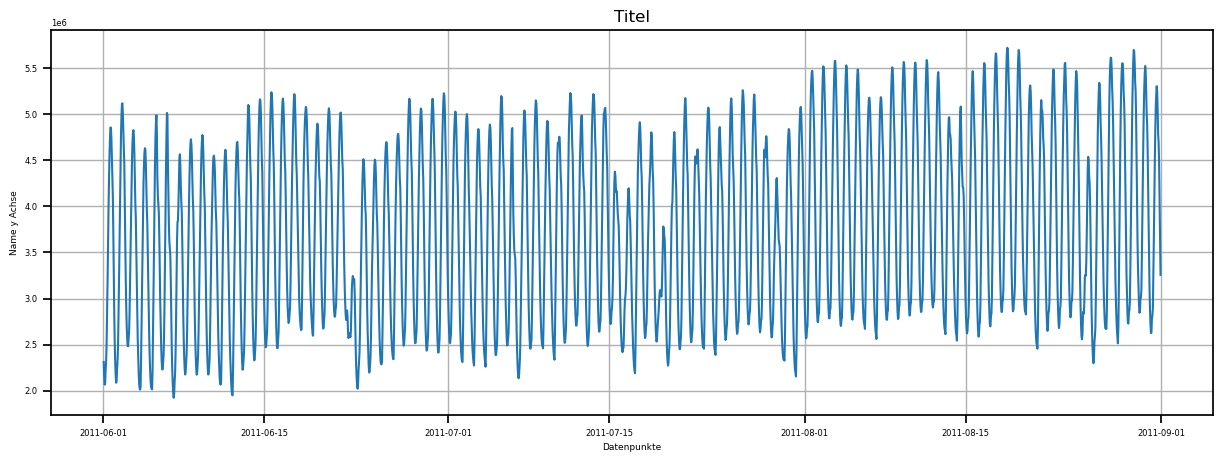

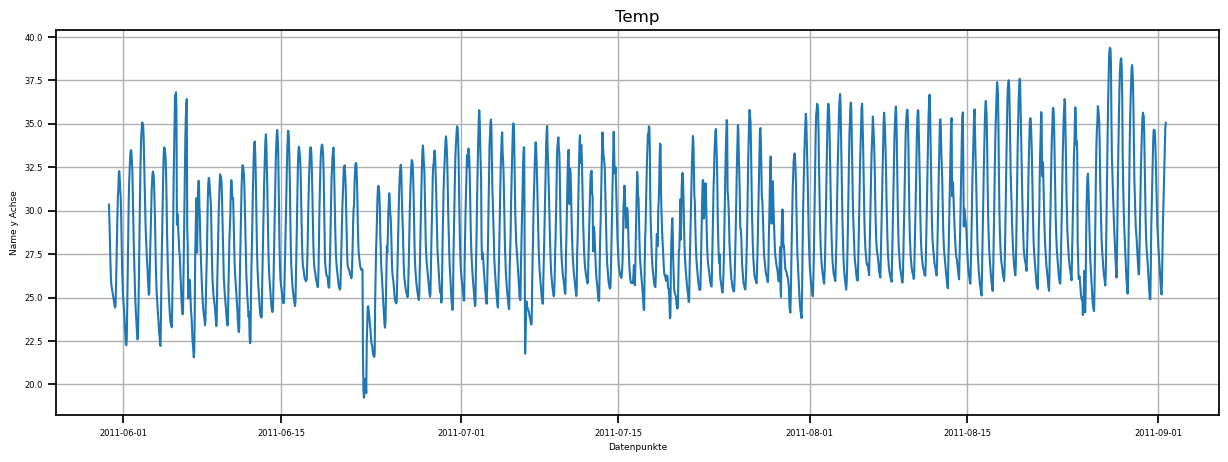

In [84]:
#Ilona: Titel, Beschriftung der Achsen (Bei dem Wetterdatensatz dementsprechend allgmein), Legende einheitlich , Zeit als Index (noch nicht das df ändern, das kommt später)und was sonst noch einfällt 
def plotDF(df, column, title, y_axis):
    plt.figure(figsize=(15, 5))

    plt.plot(df.index, df[column])

    plt.title(title)
    plt.xlabel('Datenpunkte')
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

plotDF(powerDF, 'TOTAL_LOAD', 'Titel', 'Name y Achse')
plotDF(weatherDF, 'TEMPERATURE[C]', 'Temp', 'Name y Achse')


 Beschreibung der Datensätze 
* *Spalten, INformationen, Länge(count), Aufzeichungsabstände, Lücken? Extreme Ausreißer? Zeitraum? Einheiten?

## 1.3 Datenbereinigung
Für die Übersicht und ....

### 1.3.1 Einschränkung des Zeitintervalls
Wie wir bereits festgestellt haben, stimmen die ZEitpunkte bei denen die Datenerfassung beginnt und endet bei den zwei Datensätzen nicht überein.  
Dies soll nun vereinheitlicht werden, indem wir den späteren Startzeitpunkt und den früheren Endzeitpunkt als gültiges Intervall wählen.

In [85]:
start_date = max(powerDF.index.min(), weatherDF.index.min())
end_date = min(powerDF.index.max(), weatherDF.index.max())

powerDF = powerDF.loc[start_date:end_date]
weatherDF = weatherDF.loc[start_date:end_date]

### 1.3.2 Bearbeitung unlogischer Werte
Im Großen und Ganzen haben wir logisch erscheinende Daten. Allerdings gibt es noch einige Ausreißer, die nicht physikalisch nachvollziebar wirken.   
  
So erhalten wir beispielsweise für den Niederschlag, wie oben beobachtet, in vereinzelten Fällen negative Werte.   
Diese wollen wir detektieren und untersuchen wie am besten mit ihnen umgegangen werden soll.

Je nachdem wie die Daten aussehen, wollen wir diese beispielsweise

* durch predefinierte Standardwerte ersetzen z.B 0[mm]
* durch das positiv Inverse ersetzen
* durch den Durschnitt umliegender Werte ersetzen

   
Natürlich könnten wir die betreffenden Reihen auch verwerfen, wie wir allerdings später sehen werden, steht dieser Parameter nicht wirklich im Zusammenhang mit dem zu prognosstizierenden Stromverbrauch und wird tendenziell später als Ganzes verworfen werden.  
Da ist die Kontinuität der Daten für die Prognose wichtiger, weshalb dieser nur angepasst wird.   

In [86]:
negativRainDF = weatherDF[weatherDF['RAINFALL[mm]']<0]
negativRainDF

len(negativRainDF)

,TEMPERATURE[C],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-11 12:00:00+00:00,32.641667,45.994,30.010,3.053,-0.03,7,11
2011-07-11 14:00:00+00:00,34.343889,37.866,29.978,3.484,-0.03,7,11
2011-07-11 19:00:00+00:00,31.836111,49.500,29.919,6.569,-0.03,7,11
2011-07-11 22:00:00+00:00,28.277222,67.671,29.971,5.191,-0.01,7,11
2011-07-12 07:00:00+00:00,25.927778,85.567,29.969,2.129,-0.01,7,12
2011-07-12 09:00:00+00:00,28.318889,72.986,29.993,4.433,-0.01,7,12
2011-07-13 07:00:00+00:00,24.918333,88.564,29.934,1.511,-0.01,7,13
2011-07-20 08:00:00+00:00,25.977222,85.412,29.941,1.716,-0.18,7,20


8

Wir erhalten für acht Reihen negativen Niederschlagswerte.  

Vergleichen wir die umliegenden Niederschlagswerte mit den negativen, so fällt auf, dass abseits vom Vorzeichen die Größenordnung sehr ähnlich oder sogar gleich ist.  
Unten aufegführt sind die Reihen der letzten drei betroffenen inkl. unmittelbar umliegender Werte, ähnlich verhält sich diese Beobachtung beim Rest.
  
Dies liegt nahe, dass nur das Vorzeichen falsch ist, die Zahlenwerte allerdings richtig sind. Wir entschließen uns den Betrag des Niederschlages als tatsächliche Werte aanzunehmen, um das Problem zu beseitigen.

In [87]:
for index in negativRainDF.index[-3:]:
    #Current index position in the weatherDF of correspoding negativRainDF
    idx_pos = weatherDF.index.get_loc(index)

    #DF with surrounding rows
    weatherDF.iloc[idx_pos-1:idx_pos +2]


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-12 08:00:00+00:00,27.197222,79.320,29.983,3.014,0.01,7,12
2011-07-12 09:00:00+00:00,28.318889,72.986,29.993,4.433,-0.01,7,12
2011-07-12 10:00:00+00:00,29.417222,66.580,30.002,3.390,0.01,7,12


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-13 06:00:00+00:00,24.800000,88.396,29.924,1.989,0.00,7,13
2011-07-13 07:00:00+00:00,24.918333,88.564,29.934,1.511,-0.01,7,13
2011-07-13 08:00:00+00:00,26.798889,80.056,29.948,2.797,0.00,7,13


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-20 07:00:00+00:00,24.524444,92.167,29.925,0.950,0.00,7,20
2011-07-20 08:00:00+00:00,25.977222,85.412,29.941,1.716,-0.18,7,20
2011-07-20 09:00:00+00:00,27.728889,74.943,29.950,3.259,0.18,7,20


In [88]:
weatherDF.loc[:,'RAINFALL[mm]'] = weatherDF.loc[:,'RAINFALL[mm]'].abs()

# 2. Datenanalyse

## 2.0 Kombination beider Datensätze 
Ab hier werden wir Funtkionen verwenden, für die es sinnvoll ist alle Daten in einer Struktur auffinden zu können. Da die Zeiträume und Erfassungsabstände unserer Datensätze übereinstimmen, können wir diese einfach am Index mergen.
Zudem defnieren wir eine Liste mit den Features und eine mit den Targets. Diese werden vorerst alle Wetterdaten und die Stromdaten sein.   

In [89]:
necessaryCol = powerDF.columns.difference(weatherDF.columns) #excludes duplicate columns
weather_powerDF = pd.merge(powerDF[necessaryCol], weatherDF, on='#DATE')

In [90]:
features = weatherDF.columns
targets = ['TOTAL_LOAD']

## 2.1 Linearität 

## 2.2 Periodizität
Widerholende Struktur innerhalb der daten zu beobachten, speziell in TEmperatur, Feuchtigkeit; Windstärke und Stromverbrauch. Deswegen genauere Betrachtung

<Axes: xlabel='#DATE'>

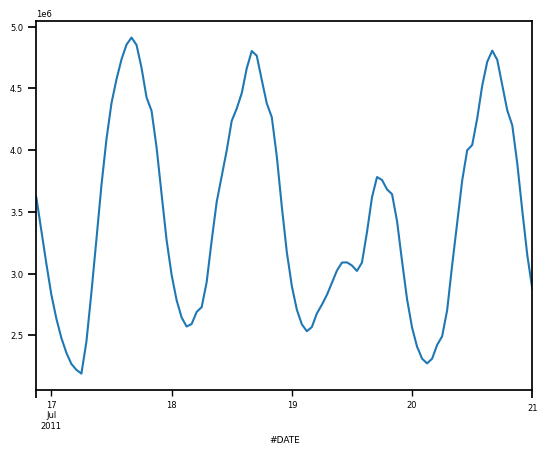

In [91]:
#PLot mit den relevanten Spalten aus beiden Dataframes
powerDF['TOTAL_LOAD'][1100:1200].plot()

## 2.3 Korrelation 

<Axes: >

Text(0.5, 1.0, 'Korrelationsmatrix der Wetter- und Stromdaten')

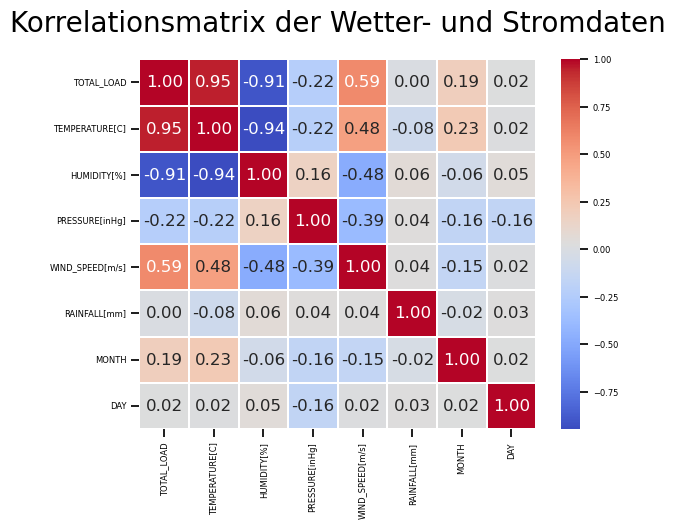

In [92]:
corrMatrix = weather_powerDF.corr()
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2)
plt.title('Korrelationsmatrix der Wetter- und Stromdaten', size=20, pad = 20)
plt.show()

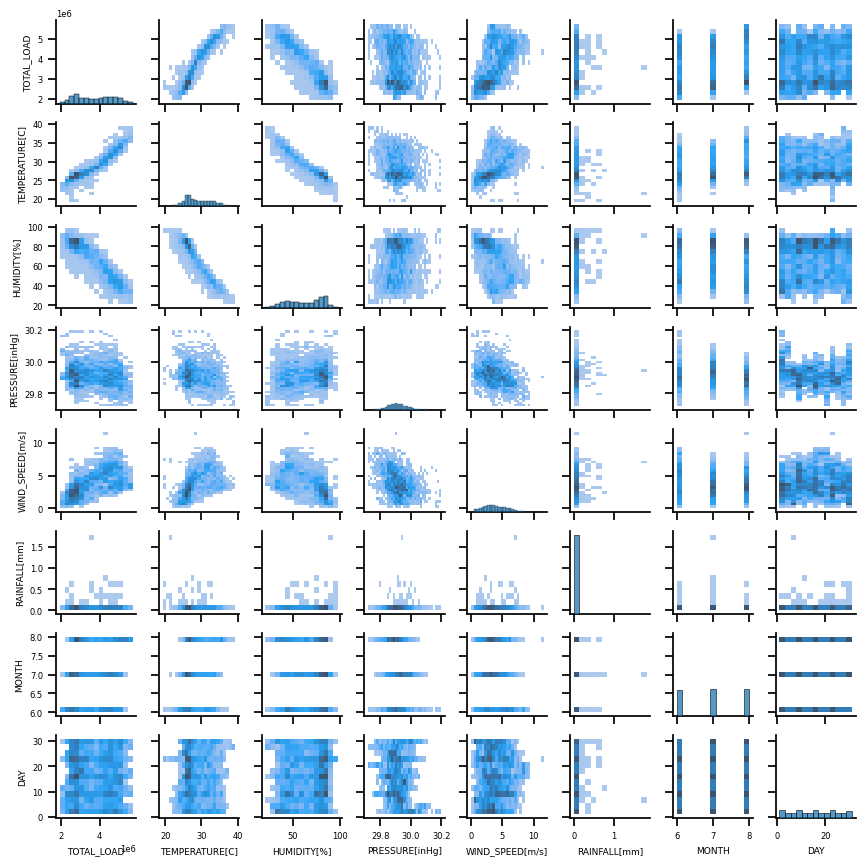

In [93]:
#Define settings for the pairplot
sns.set_context("notebook", rc={"axes.labelsize": 6.5, "xtick.labelsize": 6, "ytick.labelsize": 6})

sns.pairplot(weather_powerDF, height=1.1, kind="hist")

Was ist zu sehen? 

p Value etc. 

## 2.4 Ausreißer 

#Funktion schreiben die diese detektiert
22.06.2011 
https://www.spiegel.de/panorama/regen-hagel-sturm-tausende-haushalte-nach-unwetter-ohne-strom-a-769966.html 

19.07.2011 ??? 

<Axes: xlabel='#DATE'>

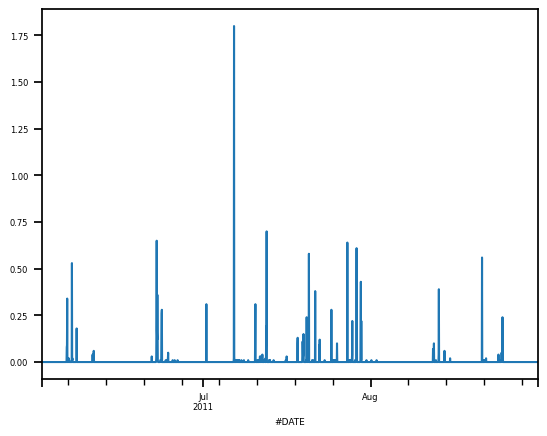

In [94]:
weatherDF['RAINFALL[mm]'].plot()

# 3. Multivariiates Lineares Modell 
Nun widmen wir uns der Aufgabenstellung den Stromverbrauch für je 1h oder 24h nach vorne vorherzusagen.  
Dazu soll ein Multivairates Lineares Modell erstellt werden.

Zunächst passen wir die Datensätze dementsprechend an, dass wir die Stromverbrauchsdaten um 1h bzw 24h verrschieben und somit eine entsprechende versetzte Zurodnung zu den Wetterdaten haben. 
MONTH und DAY wird hierbei verworfen, da es sich allerdings um die zu prognostizierenden Werte handelt, ist dies nicht weiter relevant.

In [99]:
weather_powerDF['TOTAL_LOAD_1H'] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-1))
weather_powerDF['TOTAL_LOAS_24H'] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-24))

#Add new columns to the targets list
targets += ['TOTAL_LOAD_1H', 'TOTAL_LOAD_24H']